In [5]:
import torch
import numpy as np
from scipy.optimize import linprog
from typing import Dict, Optional
from pushforward_operators.protocol import PushForwardOperator
from infrastructure.classes import TrainParameters

class LinearVectorQuantileRegression(PushForwardOperator):
    """
    Implements Linear Vector Quantile Regression using PyTorch for tensor
    operations and SciPy for the underlying linear program solver.

    Attributes:
        u (torch.Tensor | None): The reference points for the latent distribution.
        b_u (torch.Tensor | None): The learned coefficients for the linear model.
        num_latent_points_to_generate (int): The number of latent points (m) to use.
    """
    def __init__(self, num_latent_points_to_generate: int = 500):
        """
        Initializes the LinearVectorQuantileRegression operator.

        Args:
            num_latent_points_to_generate (int): The number of points 'm' for the
                                                reference distribution U.
        """
        super().__init__()
        self.u: Optional[torch.Tensor] = None
        self.b_u: Optional[torch.Tensor] = None
        self.num_latent_points_to_generate = num_latent_points_to_generate

    def to(self, *args, **kwargs):
        """
        Moves the model to the specified device and dtype.
        """
        if self.u is not None:
            self.u = self.u.to(*args, **kwargs)
        if self.b_u is not None:
            self.b_u = self.b_u.to(*args, **kwargs)
        return self

    def train(self):
        """
        Sets the model to training mode.
        """
        pass

    def eval(self):
        """
        Sets the model to evaluation mode.
        """
        pass

    def fit(self, dataloader: torch.utils.data.DataLoader, train_parameters: TrainParameters = TrainParameters(verbose=False), *args, **kwargs):
        """
        Fits the pushforward operator to the data from a DataLoader.

        Args:
            dataloader (torch.utils.data.DataLoader): Data loader providing (X, Y) batches.
            train_parameters (TrainParameters): Training parameters, e.g., {'verbose': True}.
        """
        X_Y_tuple = [(X_batch, Y_batch) for X_batch, Y_batch in dataloader]
        X_tensor = torch.cat([X_batch for X_batch, _ in X_Y_tuple], dim=0)
        Y_tensor = torch.cat([Y_batch for _, Y_batch in X_Y_tuple], dim=0)

        self.fit_tensor(X_tensor, Y_tensor, verbose=train_parameters.verbose)
        return self

    def fit_tensor(self, X_tensor: torch.Tensor, Y_tensor: torch.Tensor, verbose: bool = False):
        """
        Fits the pushforward operator directly from tensors.

        Args:
            X_tensor (torch.Tensor): The (n, p) input tensor of regressors.
            Y_tensor (torch.Tensor): The (n, d) output tensor of response variables.
            verbose (bool): Whether to print verbose output during optimization.
        """
        n, d = Y_tensor.shape
        p = X_tensor.shape[1]
        m = self.num_latent_points_to_generate

        device = X_tensor.device
        dtype = X_tensor.dtype

        U = torch.randn(m, d, device=device, dtype=dtype)
        nu = torch.ones(n, 1, device=device, dtype=dtype) / n
        mu = torch.ones(m, 1, device=device, dtype=dtype) / m

        X_np = X_tensor.cpu().numpy()
        Y_np = Y_tensor.cpu().numpy()
        U_np = U.cpu().numpy()
        nu_np = nu.cpu().numpy()
        mu_np = mu.cpu().numpy()

        result = self.solve_linear_vector_quantile_regression_primal(
            X_np, Y_np, U_np, nu_np, mu_np, verbose
        )

        b_u_np = result['eqlin']['marginals'][n:].reshape((m, p), order='F')

        self.b_u = torch.from_numpy(b_u_np).to(device=device, dtype=dtype)
        self.u = U
        return self

    def solve_linear_vector_quantile_regression_primal(
        self, X: np.ndarray, Y: np.ndarray, U: np.ndarray,
        nu: np.ndarray, mu: np.ndarray, verbose: bool = False
    ) -> Dict:
        """
        Solves the primal form of the VQR linear program using SciPy.
        This function remains unchanged and operates on NumPy arrays.

        Args:
            X (np.ndarray): The (n, p) matrix of regressors.
            Y (np.ndarray): The (n, d) matrix of response variables.
            U (np.ndarray): The (m, d) matrix of points for the reference distribution.
            nu (np.ndarray): The (n, 1) vector of probability weights for (Y, X).
            mu (np.ndarray): The (m, 1) vector of probability weights for U.
            verbose (bool): Whether to print solver output.

        Returns:
            scipy.optimize.OptimizeResult: The result from scipy.optimize.linprog.
        """
        n, _ = Y.shape
        m, _ = U.shape

        UY_transpose = U @ Y.T
        c = -UY_transpose.flatten('F')

        A_eq_a = np.kron(np.eye(n), np.ones((1, m)))
        b_eq_a = nu.flatten()

        E_X = nu.T @ X
        mu_EX = mu @ E_X
        A_eq_b = np.kron(X.T, np.eye(m))
        b_eq_b = mu_EX.flatten('F')
        A_eq = np.vstack([A_eq_a, A_eq_b])
        b_eq = np.concatenate([b_eq_a, b_eq_b])

        bounds = (0, None)

        if verbose:
            print("Solving the linear program...")

        result = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

        return result

    def push_forward_u_given_x(self, U: torch.Tensor, X: torch.Tensor) -> torch.Tensor:
        """
        Computes the pushforward map T_x(u) for given u and x.
        This is equivalent to estimating nabla_u phi(u,x).

        Args:
            U (torch.Tensor): A tensor of points u of shape (M, d) to be pushed forward.
            X (torch.Tensor): A tensor of conditions x of shape (M, p).

        Returns:
            torch.Tensor: The tensor of pushed-forward points, shape (M, d).
        """
        if self.b_u is None or self.u is None:
            raise RuntimeError("The model must be fitted before calling push_forward.")

        # The number of points in U and X must be the same
        if U.shape[0] != X.shape[0]:
            raise ValueError(f"The number of samples in U and X must be the same, but got {U.shape[0]} and {X.shape[0]}.")


        phi_u_at_x = -X @ self.b_u.T  # Shape: (M, m)

        # Estimate the gradient for each point of interest
        pushforward_of_u = self.estimate_gradients_for_points_knn(
            u_samples=self.u,
            f_samples=phi_u_at_x,
            points_of_interest=U,
            k=10
        )
        return pushforward_of_u

    def estimate_gradients_for_points_knn(
        self, u_samples: torch.Tensor, f_samples: torch.Tensor,
        points_of_interest: torch.Tensor, k: int
    ) -> torch.Tensor:
        """
        Estimates the gradient of M scalar functions at M corresponding points
        of interest using k-nearest neighbors and batched ordinary least-squares.
        This is a vectorized implementation using PyTorch.

        Args:
            u_samples (torch.Tensor): An (N, d) tensor of input sample points.
            f_samples (torch.Tensor): An (M, N) tensor of scalar function outputs.
                                    f_samples[i, j] is the value of the i-th
                                    function at the j-th sample point u_samples[j].
            points_of_interest (torch.Tensor): An (M, d) tensor of M points where
                                            the gradients are to be estimated.
            k (int): The number of nearest neighbors to use for the estimation.

        Returns:
            torch.Tensor: An (M, d) tensor containing the M estimated gradients.
        """
        if points_of_interest.ndim == 1:
            points_of_interest = points_of_interest.unsqueeze(0)

        M, d = points_of_interest.shape
        N, _ = u_samples.shape

        if u_samples.shape[1] != d:
            raise ValueError(f"Dimension mismatch: u_samples has dim {u_samples.shape[1]} but points_of_interest has dim {d}.")
        if f_samples.shape != (M, N):
            raise ValueError(f"Shape mismatch: f_samples must be ({M}, {N}) but got {f_samples.shape}.")
        if k < d + 1:
            raise ValueError(f"k must be at least d+1 (which is {d+1}) to fit a hyperplane in R^{d}.")
        if k > N:
            raise ValueError(f"k ({k}) cannot be larger than the number of samples ({N}).")

        dists_sq = torch.cdist(points_of_interest, u_samples, p=2) # Shape: (M, N)
        _, knn_indices = torch.topk(dists_sq, k, dim=1, largest=False) # Shape: (M, k)
        local_u_samples = u_samples[knn_indices] # Shape: (M, k, d)
        local_f_samples = torch.gather(f_samples, 1, knn_indices) # Shape: (M, k)

        ones = torch.ones(M, k, 1, device=u_samples.device, dtype=u_samples.dtype)
        A_design = torch.cat([local_u_samples, ones], dim=2) # Shape: (M, k, d+1)

        try:
            coeffs, _, _, _ = torch.linalg.lstsq(A_design, local_f_samples)
        except torch.linalg.LinAlgError:
            # If solving fails, return NaNs for this batch
            return torch.full((M, d), float('nan'), device=u_samples.device, dtype=u_samples.dtype)

        gradient = coeffs[:, :d]

        return gradient

    def save(self, path: str):
        """
        Saves the model's state (u and b_u tensors) to a file.

        Args:
            path (str): Path to save the model file.
        """
        if self.u is None or self.b_u is None:
            raise RuntimeError("Cannot save a model that has not been fitted.")

        state = {'u': self.u, 'b_u': self.b_u}
        torch.save(state, path)

    def load(self, path: str, map_location: torch.device = torch.device('cpu')):
        """
        Loads the model's state (u and b_u tensors) from a file.

        Args:
            path (str): Path to load the model file from.
        """
        state = torch.load(path, map_location=map_location)
        self.u = state['u']
        self.b_u = state['b_u']
        self.num_latent_points_to_generate = self.u.shape[0]
        return self


In [ ]:
import torch
import numpy as np
from scipy.optimize import linprog
from typing import Dict, Optional
from pushforward_operators.protocol import PushForwardOperator
from infrastructure.classes import TrainParameters

class LinearVectorQuantileRegression(PushForwardOperator):
    """
    Implements Linear Vector Quantile Regression using PyTorch for tensor
    operations and SciPy for the underlying linear program solver.

    Attributes:
        u (torch.Tensor | None): The reference points for the latent distribution.
        b_u (torch.Tensor | None): The learned coefficients for the linear model.
        num_latent_points_to_generate (int): The number of latent points (m) to use.
    """
    def __init__(self, num_latent_points_to_generate: int = 500):
        """
        Initializes the LinearVectorQuantileRegression operator.

        Args:
            num_latent_points_to_generate (int): The number of points 'm' for the
                                                reference distribution U.
        """
        super().__init__()
        self.u: Optional[torch.Tensor] = None
        self.b_u: Optional[torch.Tensor] = None
        self.num_latent_points_to_generate = num_latent_points_to_generate

    def to(self, *args, **kwargs):
        """
        Moves the model to the specified device and dtype.
        """
        if self.u is not None:
            self.u = self.u.to(*args, **kwargs)
        if self.b_u is not None:
            self.b_u = self.b_u.to(*args, **kwargs)
        return self

    def train(self):
        """
        Sets the model to training mode.
        """
        pass

    def eval(self):
        """
        Sets the model to evaluation mode.
        """
        pass

    def fit(self, dataloader: torch.utils.data.DataLoader, train_parameters: TrainParameters = TrainParameters(verbose=False), *args, **kwargs):
        X_Y_tuple = [(X_batch, Y_batch) for X_batch, Y_batch in dataloader]
        X_tensor = torch.cat([X_batch for X_batch, _ in X_Y_tuple], dim=0)
        Y_tensor = torch.cat([Y_batch for _, Y_batch in X_Y_tuple], dim=0)

        self.fit_tensor(X_tensor, Y_tensor, verbose=train_parameters.verbose)
        return self

    def fit_tensor(self, X_tensor: torch.Tensor, Y_tensor: torch.Tensor, verbose: bool = False):
        n, d = Y_tensor.shape
        p = X_tensor.shape[1]
        m = n + 1

        device = X_tensor.device
        dtype = X_tensor.dtype

        U = torch.randn(m, d, device=device, dtype=dtype)
        nu = torch.ones(n, 1, device=device, dtype=dtype) / n
        mu = torch.ones(m, 1, device=device, dtype=dtype) / m

        X_np = X_tensor.cpu().numpy()
        Y_np = Y_tensor.cpu().numpy()
        U_np = U.cpu().numpy()
        nu_np = nu.cpu().numpy()
        mu_np = mu.cpu().numpy()

        result = self.solve_linear_vector_quantile_regression_primal(
            X_np, Y_np, U_np, nu_np, mu_np, verbose
        )
        print(result)
        b_y_np = result['eqlin']['marginals'][n:].reshape((n, p), order='F')

        self.b_y = torch.from_numpy(b_y_np).to(device=device, dtype=dtype)
        self.y = Y_tensor
        return self

    def solve_linear_vector_quantile_regression_primal(
        self, X: np.ndarray, Y: np.ndarray, U: np.ndarray,
        nu: np.ndarray, mu: np.ndarray, verbose: bool = False
    ) -> Dict:
        n, _ = Y.shape
        m, _ = U.shape

        YU_transpose = Y @ U.T
        c = -YU_transpose.flatten('F')

        A_eq_a = np.kron(np.eye(m), np.ones((1, n)))
        b_eq_a = mu.flatten()

        E_X = mu.T @ X
        nu_EX = nu @ E_X
        A_eq_b = np.kron(X.T, np.eye(n))
        b_eq_b = nu_EX.flatten('F')
        A_eq = np.vstack([A_eq_a, A_eq_b])
        b_eq = np.concatenate([b_eq_a, b_eq_b])

        bounds = (0, None)

        if verbose:
            print("Solving the linear program...")

        result = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

        return result

    def push_y_given_x(self, y: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        if self.b_u is None or self.u is None:
            raise RuntimeError("The model must be fitted before calling push_forward.")

        # The number of points in U and X must be the same
        if y.shape[0] != x.shape[0]:
            raise ValueError(f"The number of samples in U and X must be the same, but got {y.shape[0]} and {x.shape[0]}.")


        phi_u_at_x = -x @ self.b_u.T  # Shape: (M, m)

        # Estimate the gradient for each point of interest
        pushforward_of_u = self.estimate_gradients_for_points_knn(
            y_samples=self.y,
            f_samples=phi_u_at_x,
            points_of_interest=y,
            k=10
        )
        return pushforward_of_u

    def estimate_gradients_for_points_knn(
        self, y_samples: torch.Tensor, f_samples: torch.Tensor,
        points_of_interest: torch.Tensor, k: int
    ) -> torch.Tensor:
        """
        Estimates the gradient of M scalar functions at M corresponding points
        of interest using k-nearest neighbors and batched ordinary least-squares.
        This is a vectorized implementation using PyTorch.

        Args:
            u_samples (torch.Tensor): An (N, d) tensor of input sample points.
            f_samples (torch.Tensor): An (M, N) tensor of scalar function outputs.
                                    f_samples[i, j] is the value of the i-th
                                    function at the j-th sample point u_samples[j].
            points_of_interest (torch.Tensor): An (M, d) tensor of M points where
                                            the gradients are to be estimated.
            k (int): The number of nearest neighbors to use for the estimation.

        Returns:
            torch.Tensor: An (M, d) tensor containing the M estimated gradients.
        """
        if points_of_interest.ndim == 1:
            points_of_interest = points_of_interest.unsqueeze(0)

        M, d = points_of_interest.shape
        N, _ = y_samples.shape

        if y_samples.shape[1] != d:
            raise ValueError(f"Dimension mismatch: u_samples has dim {y_samples.shape[1]} but points_of_interest has dim {d}.")
        if f_samples.shape != (M, N):
            raise ValueError(f"Shape mismatch: f_samples must be ({M}, {N}) but got {f_samples.shape}.")
        if k < d + 1:
            raise ValueError(f"k must be at least d+1 (which is {d+1}) to fit a hyperplane in R^{d}.")
        if k > N:
            raise ValueError(f"k ({k}) cannot be larger than the number of samples ({N}).")

        dists_sq = torch.cdist(points_of_interest, y_samples, p=2) # Shape: (M, N)
        _, knn_indices = torch.topk(dists_sq, k, dim=1, largest=False) # Shape: (M, k)
        local_u_samples = y_samples[knn_indices] # Shape: (M, k, d)
        local_f_samples = torch.gather(f_samples, 1, knn_indices) # Shape: (M, k)

        ones = torch.ones(M, k, 1, device=y_samples.device, dtype=y_samples.dtype)
        A_design = torch.cat([local_u_samples, ones], dim=2) # Shape: (M, k, d+1)

        try:
            coeffs, _, _, _ = torch.linalg.lstsq(A_design, local_f_samples)
        except torch.linalg.LinAlgError:
            # If solving fails, return NaNs for this batch
            return torch.full((M, d), float('nan'), device=y_samples.device, dtype=y_samples.dtype)

        gradient = coeffs[:, :d]

        return gradient

    def save(self, path: str):
        """
        Saves the model's state (u and b_u tensors) to a file.

        Args:
            path (str): Path to save the model file.
        """
        if self.u is None or self.b_u is None:
            raise RuntimeError("Cannot save a model that has not been fitted.")

        state = {'u': self.u, 'b_u': self.b_u}
        torch.save(state, path)

    def load(self, path: str, map_location: torch.device = torch.device('cpu')):
        """
        Loads the model's state (u and b_u tensors) from a file.

        Args:
            path (str): Path to load the model file from.
        """
        state = torch.load(path, map_location=map_location)
        self.u = state['u']
        self.b_u = state['b_u']
        self.num_latent_points_to_generate = self.u.shape[0]
        return self


In [3]:
from infrastructure.classes import Experiment, TrainParameters
from infrastructure.training import train
import torch

experiment = Experiment(
    tensor_parameters=dict(dtype=torch.float64, device=torch.device("cpu")),
    dataset_name="star",
    dataset_number_of_points=1000,
    dataset_parameters={"n_lobes": 4, "seed":1},
    dataloader_parameters=dict(batch_size=256, shuffle=True),
    pushforward_operator_name="linear_vector_quantile_regression",
    pushforward_operator_parameters=dict(num_latent_points_to_generate=600),
    train_parameters=TrainParameters(verbose=True)
)

model = train(experiment)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1000 is different from 1001)

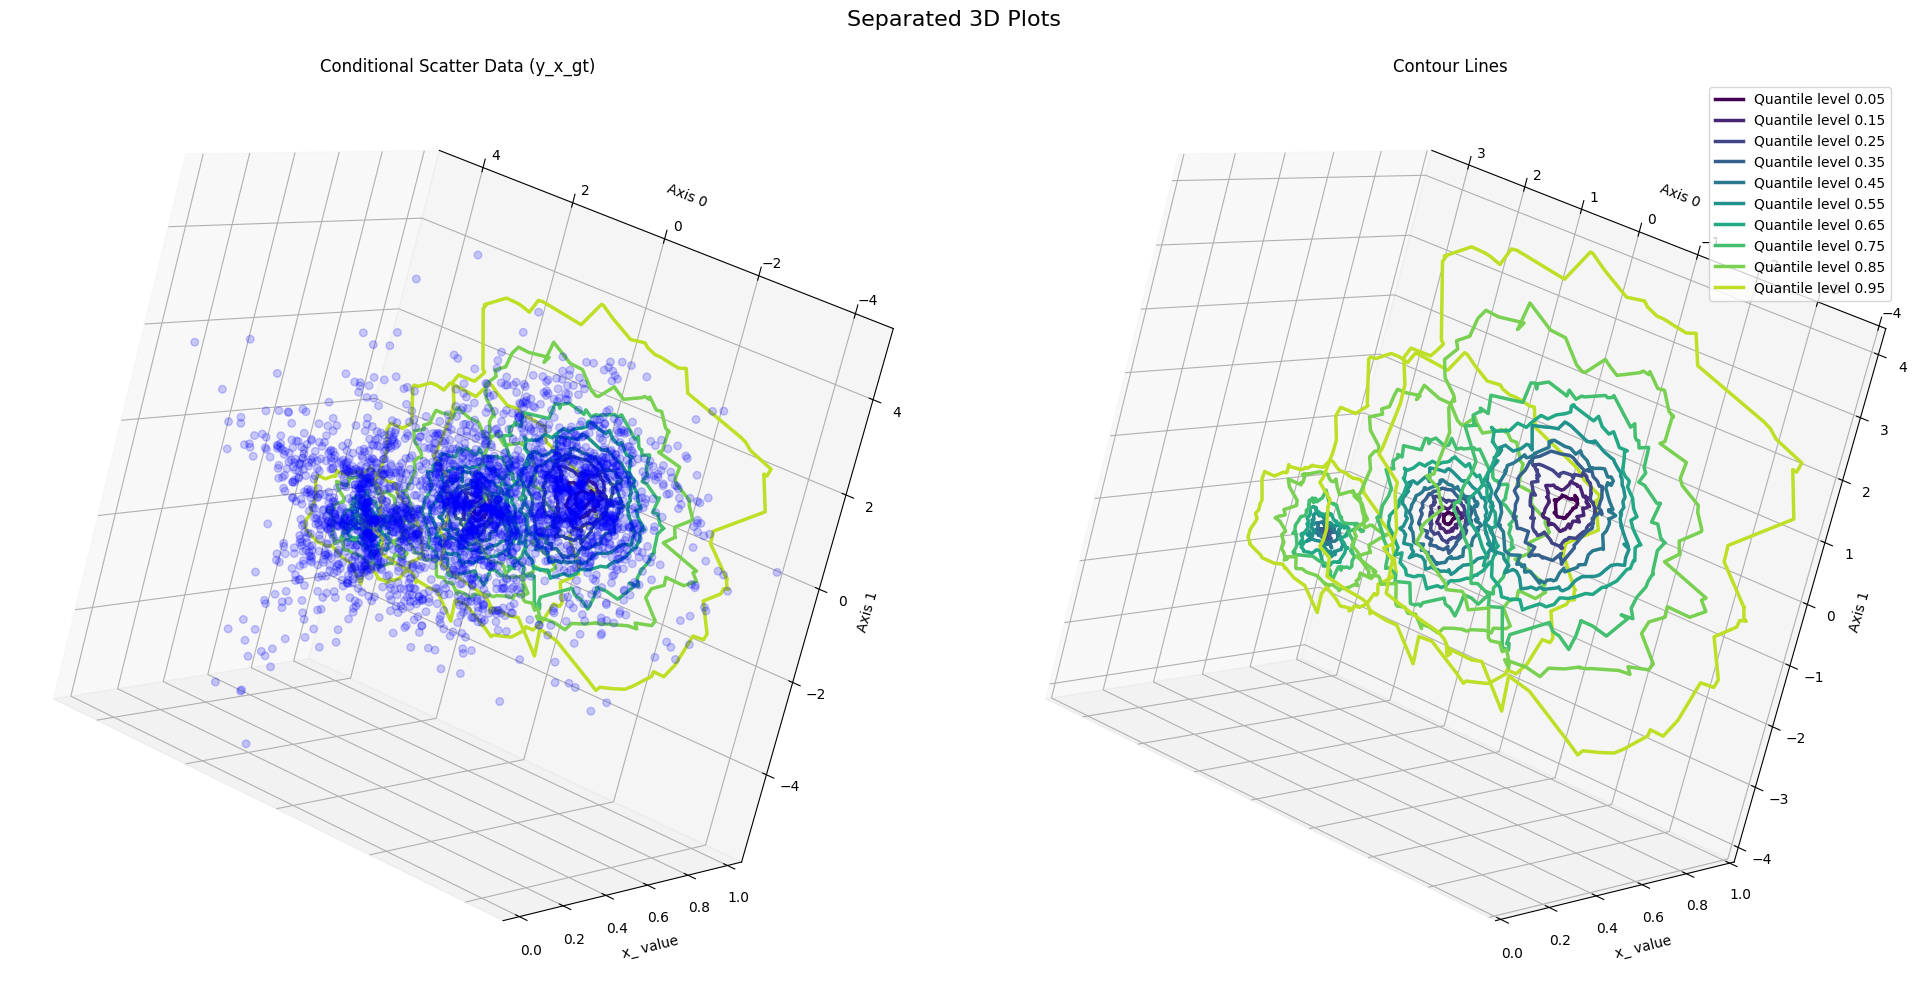

In [28]:
%matplotlib inline

from utils.plot import plot_potentials_from_star_dataset

plot_potentials_from_star_dataset(model, 3, 1000, experiment.tensor_parameters, experiment.dataset_parameters)

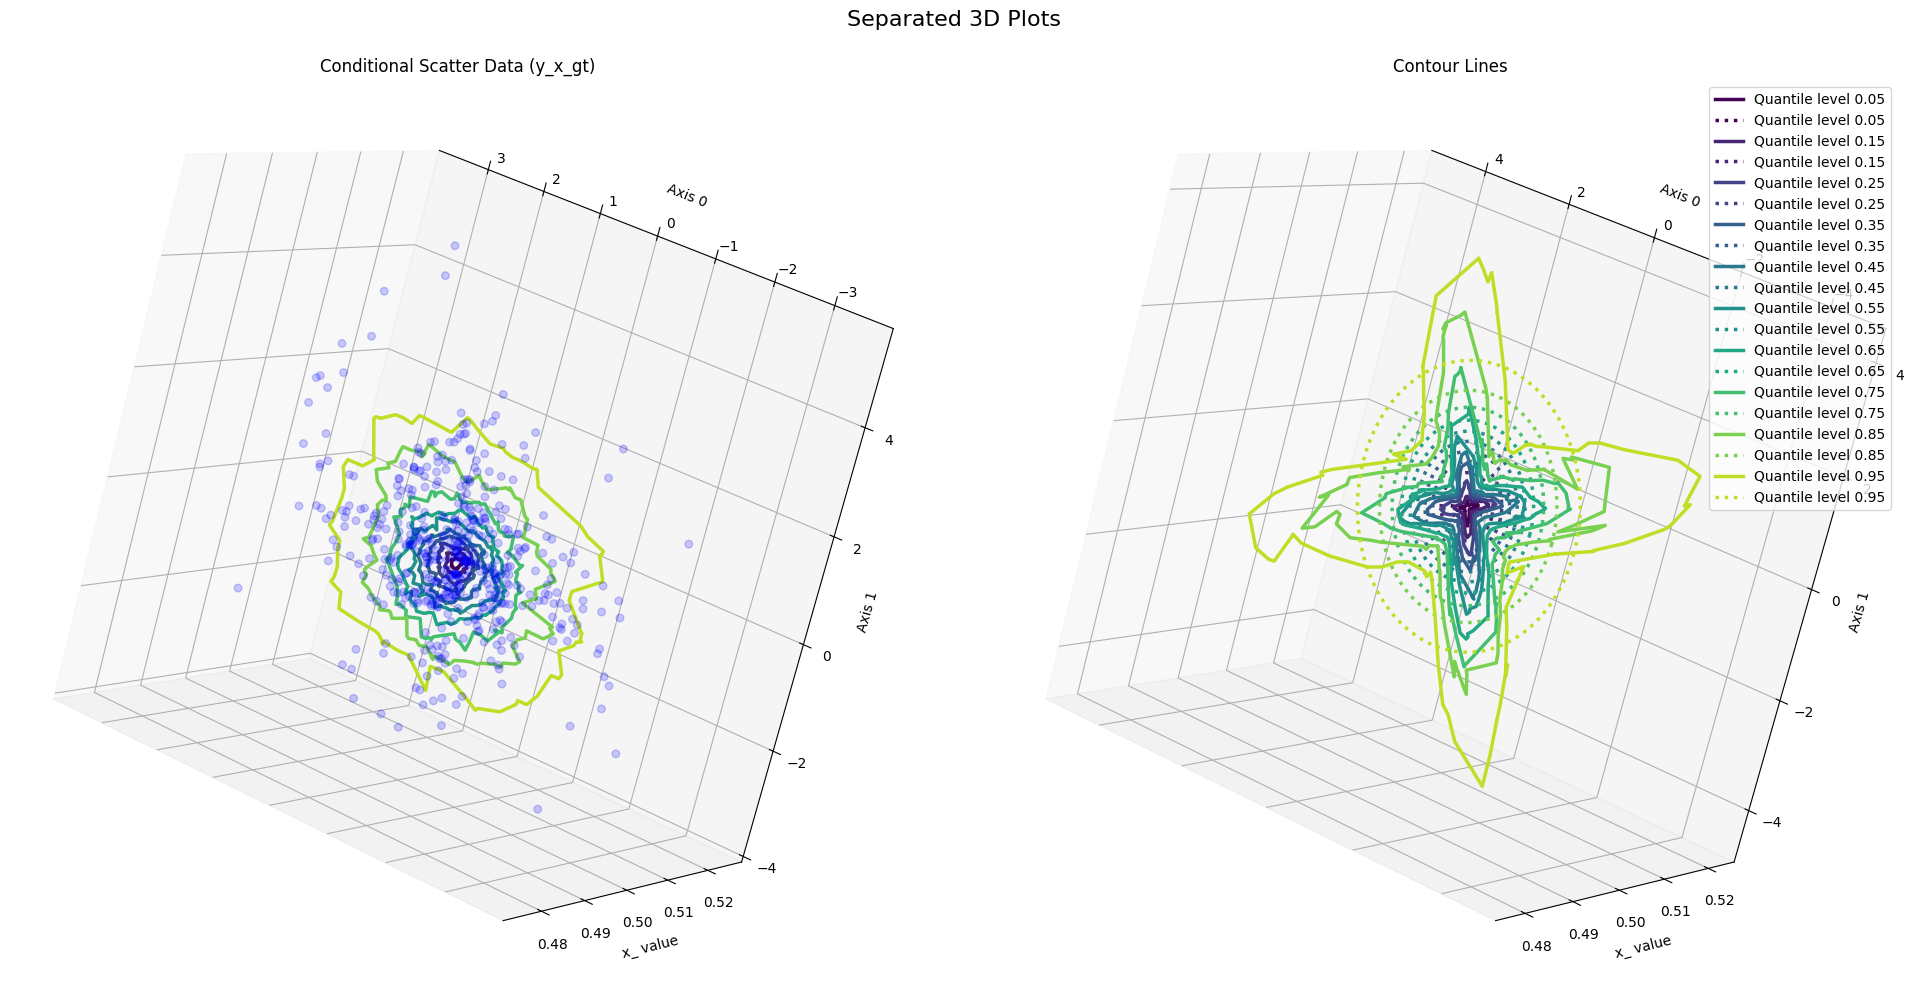

In [27]:
%matplotlib inline

from utils.plot import plot_quantile_levels_from_star_dataset

plot_quantile_levels_from_star_dataset(model, 500, experiment.tensor_parameters, 0.5, 10, experiment.dataset_parameters)